TASK目标：本次任务的目的是实践迁移学习算法，这是一个非常有用的DL技巧。

具体到本次学习，任务如下：

（1）请首先学习样本代码文档；

（2）查阅Keras文档，其中还有很多经典 DL 模型，请随意挑选一个，并迁移至猫狗大战问题上，看看精度如何？

（3）请详细注释程序代码，以确认你是否真的理解。加油！

# <center><h1> 迁移学习：站在牛人的肩膀上 </h1></center>

# 学习DL的困难

> 经典网络太多了：LeNet，AlexNet，VGG16，Inception.V1+V2+V3，ResNet+ResNext，DenseNet，MobileNet

> 计算太昂贵：（1）硬件，CPU+GPU+TPU；（2）数据：ImageNet

> 有没有讨巧的方案：站在牛人的肩膀上？


# 数据生成器：Validation

In [1]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator    # 图片预处理

IMSIZE=299    # 图片像素

validation_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input).flow_from_directory(
    './data/CatDog/validation',  # 数据路径
    target_size=(IMSIZE, IMSIZE),  # 数据像素（目标大小）
    batch_size=100,             # 批处理大小
    class_mode='categorical')    # 生成验证数据集


Using TensorFlow backend.


Found 10000 images belonging to 2 classes.


# 数据生成器：Train

In [2]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # 数据预处理
    shear_range=0.5,   # 一定角度下的斜方向拉伸强度不超过0.5
    rotation_range=30,  # 图片右旋转不超过30°
    zoom_range=0.2,     # 定义放大或缩小比例不超多0.2
    width_shift_range=0.2,   # 水平方向上平移不超过0.2的宽度
    height_shift_range=0.2,   # 垂直方向的平移不超过0.2的高度
    horizontal_flip=True).flow_from_directory(  # 允许水平和竖直方向的翻转
    './data/CatDog/train',   # 数据路径
    target_size=(IMSIZE, IMSIZE),  # 数据像素（目标大小）
    batch_size=150,                # 批处理大小
    class_mode='categorical')      # 生成训练数据集

Found 15000 images belonging to 2 classes.


# 数据展示

<Figure size 432x288 with 0 Axes>

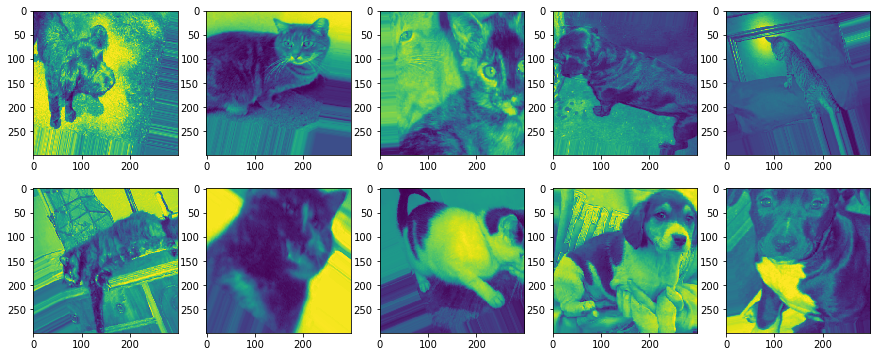

In [3]:
from matplotlib import pyplot as plt   # 导入画板

plt.figure()   # 创建画板
fig,ax = plt.subplots(2,5)   # 将面板切分成2行5列
fig.set_figheight(6)    # 高为6
fig.set_figwidth(15)     # 宽为15
ax=ax.flatten()       # 拉直
X,Y=next(train_generator)    # 分批吐出数据
for i in range(10): ax[i].imshow(X[i,:,:,0])   # 展示

# 迁移学习模型

首先执行下面的代码，将模型文件复制到本地的~/.keras/models 目录中，这样可以避免直接从github中下载模型，速度过慢

In [4]:
!mkdir -p ~/.keras/models
!cp /clubear/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 ~/.keras/models

In [5]:
from keras.applications.inception_v3 import InceptionV3   # 迁移学习
from keras.layers import GlobalAveragePooling2D, Dense, Activation   # 导入各种层函数
from keras import Model   # 模型

base_model = InceptionV3(weights='imagenet', include_top=False)  # 基础模型，放弃所有顶层输出的神经元
x = base_model.output        # 嫁接，输出赋值
x = GlobalAveragePooling2D()(x)   # 将每个通道矩阵变为单一数值，全连接输出层向量
predictions = Dense(2,activation='softmax')(x)   # 2个节点的全连接层
model=Model(inputs=base_model.input, outputs=predictions)  # 指定模型输入和输出
for layer in base_model.layers:     
    layer.trainable = False         # 权重继承
model.summary()     # 模型结构

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

# 模型拟合结果

In [6]:
from keras.optimizers import Adam     # 导⼊优化器Adam
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
#模型编译，损失函数为交叉熵；优化器为Adam；学习速率为0.001 ；衡量指标为精度
model.fit_generator(train_generator,epochs=1,validation_data=validation_generator)
# 训练1轮；模型训练，⽤训练集

Epoch 1/1
100/100 [==============================] - 708s 7s/step - loss: 0.2286 - accuracy: 0.9173 - val_loss: 0.0582 - val_accuracy: 0.9815


# 思考问题：迁移其他模型？？

In [3]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
from keras import callbacks
from keras.models import Sequential, model_from_yaml, load_model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
from keras.utils import np_utils, plot_model 
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import preprocess_input, decode_predictions   

In [4]:
from keras.preprocessing.image import ImageDataGenerator  # 图片预处理

IMSIZE=128   # 图片像素

validation_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input).flow_from_directory(
    'F:/大三（上）/深度学习/TASK5.1：DL核心技术 - BN + DA/dogs-vs-cats/train/test',   # 数据路径
    target_size=(IMSIZE, IMSIZE),   # 数据像素（目标大小）
    batch_size=150,class_mode='categorical')                # 批处理大小  # 生成验证数据集

train_generator = ImageDataGenerator(    
    preprocessing_function=preprocess_input,   # 数据预处理
    shear_range=0.3,   # 一定角度下的斜方向拉伸强度不超过0.3
    rotation_range=20,  # 图片右旋转不超过20°
    zoom_range=0.3,     # 定义放大或缩小比例不超多0.3
    width_shift_range=0.2,   # 水平方向上平移不超过0.2的宽度
    height_shift_range=0.2,   # 垂直方向的平移不超过0.2的高度
    horizontal_flip=True).flow_from_directory(
    'F:/大三（上）/深度学习/TASK5.1：DL核心技术 - BN + DA/dogs-vs-cats/train/train',
    target_size=(IMSIZE, IMSIZE),
    batch_size=150)  

Found 2500 images belonging to 2 classes.
Found 22500 images belonging to 2 classes.


In [5]:
import numpy as np   # 导入库
X,Y=next(validation_generator)   # 分批吐出数据
print(X.shape)
print(Y.shape)
Y[:,0]                # 矩阵

(150, 128, 128, 3)
(150, 2)


array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

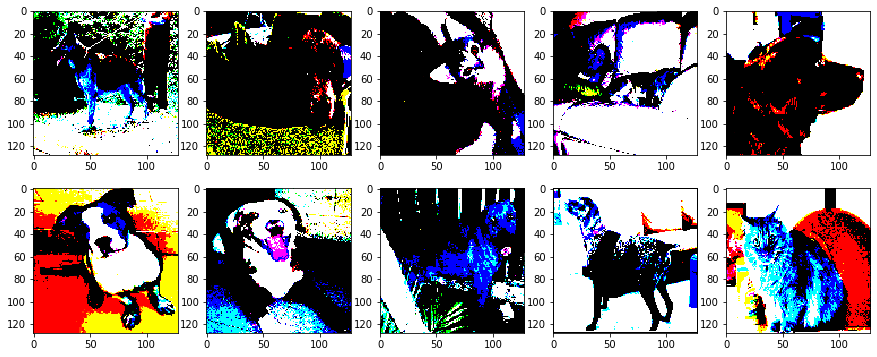

In [6]:
from matplotlib import pyplot as plt    # 导入画板
plt.figure()                  # 创建画板
fig,ax = plt.subplots(2,5)    # 将面板切分成2行5列
fig.set_figheight(6)          # 高为6
fig.set_figwidth(15)          # 宽为15
ax=ax.flatten()               # 拉直
for i in range(10): ax[i].imshow(X[i,:,:,:])   # 展示

### 案例改编版 

In [14]:
from shutil import copy2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [16]:
# 构建不带分类器的预训练模型
base_model = InceptionV3(weights='imagenet', include_top=False)

# 添加全局平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)

# 添加一个全连接层
x = Dense(1024, activation='relu')(x)

# 添加一个分类器，假设我们有200个类
prediction = Dense(1, activation='sigmoid')(x)

# 首先，我们只训练顶部的几层（随机初始化的层）
# 锁住所有 InceptionV3 的卷积层
for layer in base_model.layers:
    layer.trainable = False
model = Model(inputs=base_model.input, outputs=prediction)
# 编译模型
model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()     # 模型结构

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_97[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [18]:
from keras.optimizers import Adam     # 导⼊优化器Adam
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
#模型编译，损失函数为交叉熵；优化器为Adam；学习速率为0.001 ；衡量指标为精度
model.fit_generator(train_generator,epochs=1,validation_data=validation_generator)
# 训练1轮；模型训练，⽤训练集

150/150 [==============================] - 968s 6s/step - loss: 1.1921e-07 - accuracy: 0.5000 - val_loss: 1.1921e-07 - val_accuracy: 0.5000


###  VGG16

In [26]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Activation,Dropout,Flatten,Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

In [27]:
 vgg16_model = VGG16(weights='imagenet',include_top=False, input_shape=(150,150,3))

In [28]:
 vgg16_model.summary()    

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [30]:
 # 搭建全连接层
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256,activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2,activation='softmax'))
model1 = Sequential()
model1.add(vgg16_model)
model1.add(top_model)

In [ ]:
# 定义优化器，代价函数，训练过程中计算准确率
model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model1.fit_generator(train_generator,epochs=1,validation_data=validation_generator)

 95/150 [==================>...........] - ETA: 54:57 - loss: 10.1764 - accuracy: 0.5481